# Kaggle Setup




In [1]:
!printf '{"username":"sukrit966","key":"subKeyHere"}' > kaggle.json

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [3]:
!kaggle datasets download andrewmvd/face-mask-detection -p /content/sample_data/ --unzip

100% 397M/398M [00:20<00:00, 21.1MB/s]
100% 398M/398M [00:20<00:00, 20.6MB/s]


In [4]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset 2

In [5]:
from bs4 import BeautifulSoup

def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 1
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [6]:
imgs = list(sorted(os.listdir("/content/sample_data/images")))
len(imgs)

853

In [7]:
labels = list(sorted(os.listdir("/content/sample_data/annotations")))


In [8]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/content/sample_data/images/", file_image)
    label_path = os.path.join("/content/sample_data/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [9]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
no_faces = 0
no_mask = 0
for i in range(853):
    img_path = r"/content/sample_data/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        #img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        #img1 = np.reshape(img1,(100,100,1))
        img1 = img_to_array(img1)
        #img1 = img1/255
        #bimg1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [11]:
aug = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)


In [12]:
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.1, stratify=labels, random_state=42)

In [13]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
import keras
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
opt = Adam(learning_rate=1e-3)

# model = Sequential()
# model.add(Conv2D(200, (3, 3), activation = "relu", input_shape=(100, 100,1),kernel_regularizer =tf.keras.regularizers.l2( l=0.01) ))#input kya hoga??
# model.add(MaxPool2D(pool_size=(3, 3)))
# model.add(Conv2D(100, (3, 3), activation = "relu",kernel_regularizer =tf.keras.regularizers.l2( l=0.01) ))
# model.add(MaxPool2D(pool_size=(3, 3)))
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation = "relu"))
# model.add(Dense(2, activation = "softmax"))

# Modified model
model = Sequential()
model.add(Conv2D(200, (3, 3), activation = "relu", input_shape=(100, 100,3), kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(200, (3, 3), activation = "relu", kernel_regularizer =tf.keras.regularizers.l2( l=0.01) ))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Dropout(0.5))
model.add(Conv2D(100, (3, 3), activation = "relu", kernel_regularizer =tf.keras.regularizers.l2( l=0.01) ))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


H = model.fit(
	aug.flow(trainX, trainY, batch_size=64,subset='training'),
	#steps_per_epoch=len(trainX) // 64,
	validation_data=aug.flow(trainX,trainY,batch_size=64,subset='validation'),
	#validation_steps=len(Y_valid) // 64,
	epochs=20,
	callbacks=[model_checkpoint_callback],
	class_weight = {0:3, 1:1})

Epoch 1/20
46/46 [==============================] - 20s 226ms/step - loss: 2.0525 - accuracy: 0.8155 - val_loss: 0.6376 - val_accuracy: 0.9016
Epoch 2/20
46/46 [==============================] - 11s 230ms/step - loss: 0.6493 - accuracy: 0.8874 - val_loss: 0.3488 - val_accuracy: 0.9440
Epoch 3/20
46/46 [==============================] - 10s 219ms/step - loss: 0.4938 - accuracy: 0.9137 - val_loss: 0.2630 - val_accuracy: 0.9508
Epoch 4/20
46/46 [==============================] - 10s 211ms/step - loss: 0.4364 - accuracy: 0.9144 - val_loss: 0.2484 - val_accuracy: 0.9467
Epoch 5/20
46/46 [==============================] - 10s 214ms/step - loss: 0.3955 - accuracy: 0.9253 - val_loss: 0.3070 - val_accuracy: 0.9016
Epoch 6/20
46/46 [==============================] - 10s 216ms/step - loss: 0.3814 - accuracy: 0.9304 - val_loss: 0.2079 - val_accuracy: 0.9522
Epoch 7/20
46/46 [==============================] - 10s 210ms/step - loss: 0.4148 - accuracy: 0.9110 - val_loss: 0.1972 - val_accuracy: 0.9508

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 200)       360200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 200)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 200)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 100)         1

In [16]:
max(H.history['val_accuracy'])


0.9549180269241333

In [17]:
def plot(history):
  N = 20
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")

In [18]:
print("Evaluate")
result = model.evaluate(aug.flow(testX,testY))
print(result)

Evaluate
13/13 [==============================] - 1s 89ms/step - loss: 0.2035 - accuracy: 0.9461
[0.2034827172756195, 0.9460784196853638]


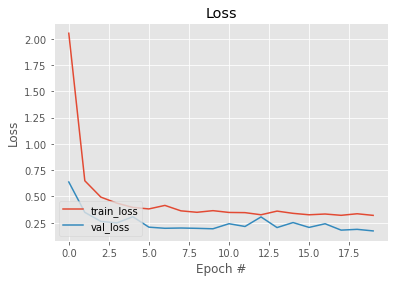

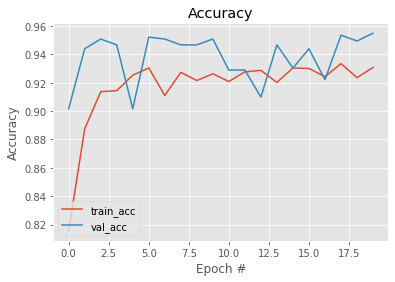

In [19]:
plot(H)

In [20]:
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

13/13 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.82      1.00      0.90       336

    accuracy                           0.82       408
   macro avg       0.41      0.50      0.45       408
weighted avg       0.68      0.82      0.74       408



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


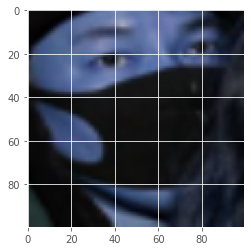

In [ ]:
plt.imshow(trainX[1]/255)

In [ ]:
np.where(trainY == [1.,0.])

(array([  10,   10,   13, ..., 3652, 3656, 3656]),
 array([0, 1, 0, ..., 1, 0, 1]))

In [ ]:
trainY[1]

array([0., 1.], dtype=float32)

# Remaining code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
DATADIR = "/content/gdrive/MyDrive/DL_dataset/observations-master.zip"
CATEGORIES = ['without_mask', 'with_mask']

In [ ]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 37.69 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
data_path = "/content/observations/experiements/data"

In [ ]:
categories=os.listdir(data_path)

In [ ]:
print(categories)

['with_mask', 'without_mask']


In [ ]:
labels=[i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))

In [ ]:
print(label_dict)

{'with_mask': 0, 'without_mask': 1}


In [ ]:
dataset = {
    "image_path": [],
    "mask_status": [],
}

for status in os.listdir(data_path):
  for image in glob.glob(data_path+"/"+status+"/"+"*.jpg"):
    dataset["image_path"].append(image)
    dataset["mask_status"].append(status)
            
dataset = pd.DataFrame(dataset)
dataset.head(10)

,image_path,mask_status
0,/content/observations/experiements/data/with_m...,with_mask
1,/content/observations/experiements/data/with_m...,with_mask
2,/content/observations/experiements/data/with_m...,with_mask
3,/content/observations/experiements/data/with_m...,with_mask
4,/content/observations/experiements/data/with_m...,with_mask
5,/content/observations/experiements/data/with_m...,with_mask
6,/content/observations/experiements/data/with_m...,with_mask
7,/content/observations/experiements/data/with_m...,with_mask
8,/content/observations/experiements/data/with_m...,with_mask
9,/content/observations/experiements/data/with_m...,with_mask


In [ ]:
dataset = dataset.sample(frac=1)
dataset.head(10)

,image_path,mask_status
409,/content/observations/experiements/data/with_m...,with_mask
220,/content/observations/experiements/data/with_m...,with_mask
190,/content/observations/experiements/data/with_m...,with_mask
799,/content/observations/experiements/data/withou...,without_mask
988,/content/observations/experiements/data/withou...,without_mask
142,/content/observations/experiements/data/with_m...,with_mask
647,/content/observations/experiements/data/with_m...,with_mask
1344,/content/observations/experiements/data/withou...,without_mask
1172,/content/observations/experiements/data/withou...,without_mask
351,/content/observations/experiements/data/with_m...,with_mask


In [ ]:
dataset = dataset.reset_index().drop("index", axis = 1)
dataset.head(10)

,image_path,mask_status
0,/content/observations/experiements/data/with_m...,with_mask
1,/content/observations/experiements/data/with_m...,with_mask
2,/content/observations/experiements/data/with_m...,with_mask
3,/content/observations/experiements/data/withou...,without_mask
4,/content/observations/experiements/data/withou...,without_mask
5,/content/observations/experiements/data/with_m...,with_mask
6,/content/observations/experiements/data/with_m...,with_mask
7,/content/observations/experiements/data/withou...,without_mask
8,/content/observations/experiements/data/withou...,without_mask
9,/content/observations/experiements/data/with_m...,with_mask


In [ ]:
data = []
image_size = 100

for i in range(len(dataset)):
    ## Converting the image into grayscale
    img_array = cv2.imread(dataset["image_path"][i])
    img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
    ## Normalize
    #norm_image = cv2.normalize(new_image_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ## reshaping image
    #norm_image=np.reshape(norm_image,(norm_image.shape[0],image_size,image_size,1))
    ##Encoding the image with the label
    if dataset["mask_status"][i] == "with_mask":
        data.append([new_image_array, [1,0]])
    else:
        data.append([new_image_array, [0,1] ])

In [ ]:
data

In [ ]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
X

In [ ]:
X = X/255

In [ ]:
X

In [ ]:
X=np.reshape(X,(X.shape[0],100,100,1))

In [ ]:
X

In [ ]:
X.shape[1:]

(100, 100, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(200, (3, 3), activation = "relu", input_shape=(100, 100,1)))#input kya hoga??
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       2000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dropout (Dropout)           (None, 10000)             0

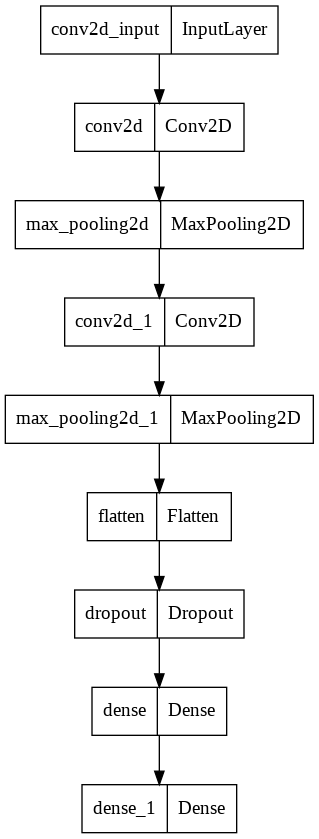

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
opt = Adam(learning_rate=0.01)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size = 64,validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 53s 3s/step - loss: 3.6358 - accuracy: 0.5081 - val_loss: 0.6955 - val_accuracy: 0.4677
Epoch 2/20
16/16 [==============================] - 42s 3s/step - loss: 0.6928 - accuracy: 0.5202 - val_loss: 0.6946 - val_accuracy: 0.4677
Epoch 3/20
16/16 [==============================] - 52s 3s/step - loss: 0.6927 - accuracy: 0.5202 - val_loss: 0.6963 - val_accuracy: 0.4677
Epoch 4/20
16/16 [==============================] - 42s 3s/step - loss: 0.6923 - accuracy: 0.5202 - val_loss: 0.6970 - val_accuracy: 0.4677
Epoch 5/20
16/16 [==============================] - 43s 3s/step - loss: 0.6924 - accuracy: 0.5202 - val_loss: 0.6975 - val_accuracy: 0.4677
Epoch 6/20
16/16 [==============================] - 41s 3s/step - loss: 0.6926 - accuracy: 0.5202 - val_loss: 0.6980 - val_accuracy: 0.4677
Epoch 7/20
16/16 [==============================] - 42s 3s/step - loss: 0.6924 - accuracy: 0.5202 - val_loss: 0.6971 - val_accuracy: 0.4677
Epoch 8/20
16/16 [==

KeyboardInterrupt: ignored

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.evaluate(X_val,y_val)